<div align='center'><font size="5" color='#353B47'>Predicting Stock Prices</font></div>
<div align='center'><font size="4" color="#353B47">How to use LSTMs</font></div>
<br>
<hr>

**<font color="blue" size="4">Context</font>**

> This notebook aims at showing a short script on how to predict stock prices using a LSTM model. An introduction has been made about <a href="https://www.kaggle.com/bryanb/introduction-to-time-series-analysis/edit/run/53321733">Time Series Analysis</a>, if you haven't read it yet, do not hesitate to give a look

**<font color="blue" size="4">Reminder</font>**

> A Time Series is a **time-indexed** series of data. In Finance, a time series tracks the movement of the chosen data points, such as a *security's price*, over a specified period of time with data points recorded at **regular intervals**.

<img src="https://miro.medium.com/max/1400/1*NpT5pyemQQsGEHXbfS51Zw.png" width="500">

**<font color="blue" size="4">Why is it used for ?</font>**

> Time series analysis can be useful to see how a given asset, security, or economic variable changes over time. It can also be used to examine how the changes associated with the chosen data point compare to shifts in other variables over the same time period.
>
> For example, suppose you wanted to analyze a time series of daily closing stock prices for a given stock over a period of one year. You would obtain a list of all the closing prices for the stock from each day for the past year and list them in chronological order. 

## <div id="summary">Summary</div>

**<font size="2"><a href="#chap1">1. Import libraries</a></font>**
**<br><font size="2"><a href="#chap2">2. Preprocessing</a></font>**
**<br><font size="2"><a href="#chap3">3. Build LSTM model</a></font>**
**<br><font size="2"><a href="#chap4">4. Training</a></font>**
**<br><font size="2"><a href="#chap5">5. Predictions</a></font>**

# <div id="chap1">1. Import libraries

In [1]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
# import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
import yfinance as yf

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap2">2. Preprocessing

In [3]:
COMPANY = '^GSPC'


In [4]:
data = yf.download(COMPANY, start='2000-01-01', end='2022-01-01')
len(data)

[*********************100%***********************]  1 of 1 completed


5536

In [5]:
array_data = np.array(data['Close'])
n_data = array_data.size
time_data = np.arange(0, n_data)
Polynomial = np.polyfit(time_data, array_data, 1)
data_notrend = array_data - Polynomial[0] * time_data  # detrended x
data['Close'] = data_notrend

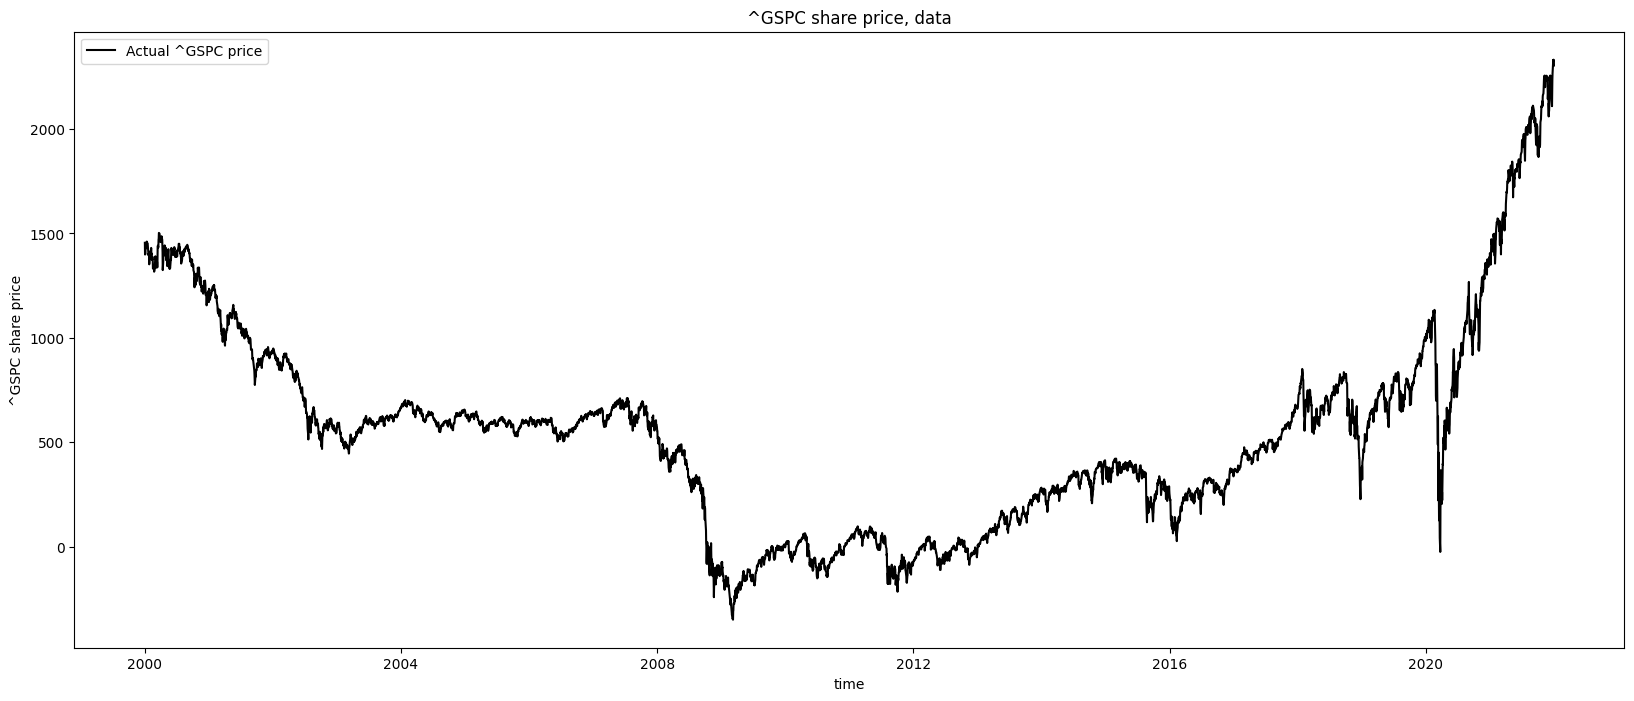

In [6]:
plt.figure(figsize=(20, 8))
plt.plot(data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, data")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [7]:
import math
math.ceil(len(data)*0.8)

4429

In [8]:
train_data = data[0:math.ceil(len(data)*0.8)]
print(len(train_data))
test_data = data[math.ceil(len(data)*0.8):]
print(len(test_data))

4429
1107


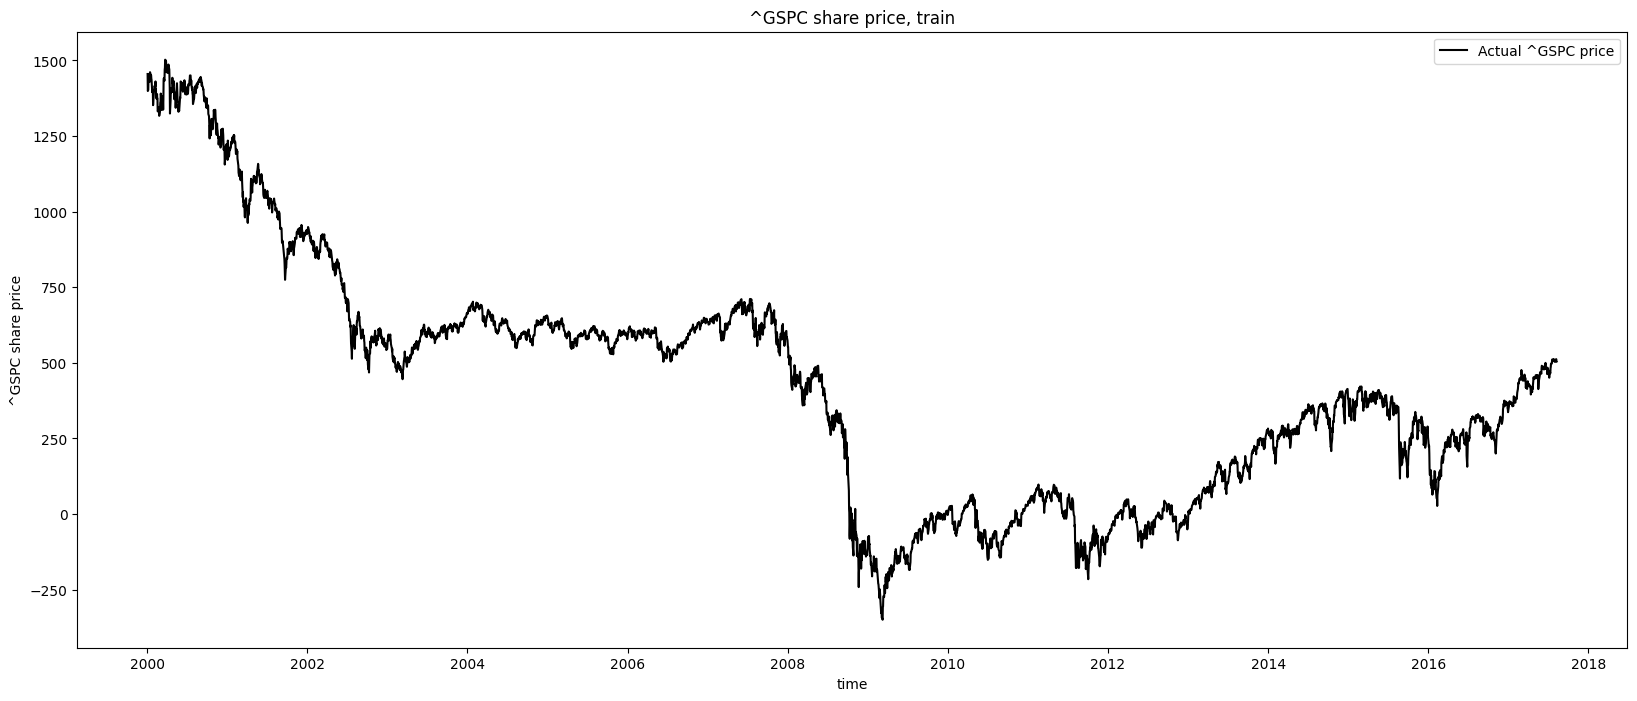

In [9]:
plt.figure(figsize=(20, 8))
plt.plot(train_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, train")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

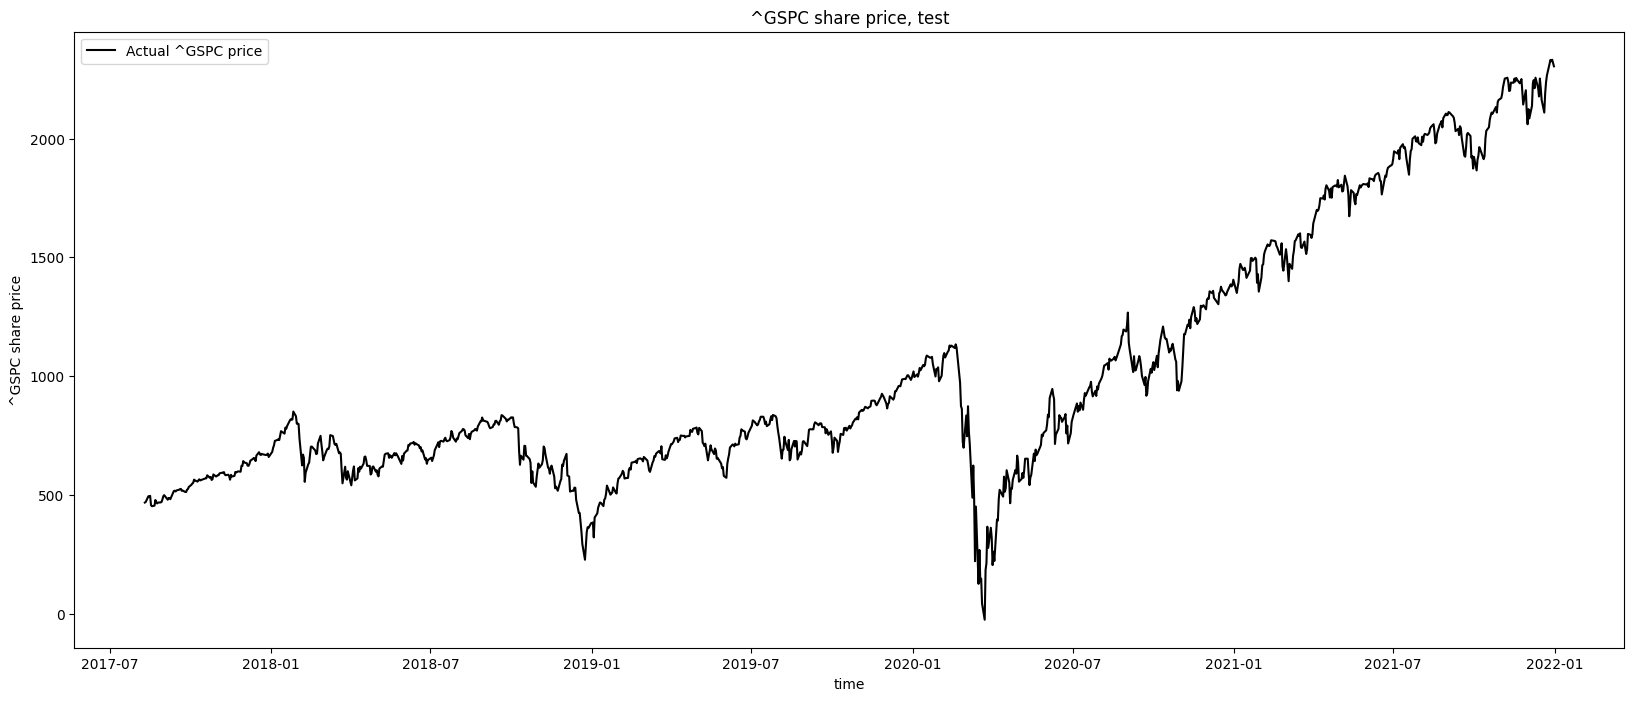

In [10]:
plt.figure(figsize=(20, 8))
plt.plot(test_data['Close'], 'black', label=f"Actual {COMPANY} price")
plt.title(f"{COMPANY} share price, test")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

In [11]:
# Normalize data
scaler = MinMaxScaler(feature_range=(-1,1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))

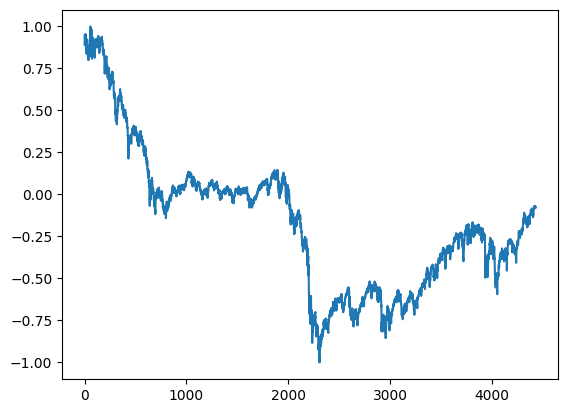

In [12]:
plt.plot(scaled_data)

In [13]:
# how many days do i want to base my predictions on ?
base_day = 30
prediction_day = 10
x_train = []
y_train = []
# 從base_day開始，往前提取base_day天的數據，作為輸入變量x_train，並將當前價格作為輸出變量y_train
for x in range(base_day+prediction_day, len(scaled_data)):
    x_train.append(scaled_data[x-base_day-prediction_day:x-prediction_day, 0])
    y_train.append(scaled_data[x-prediction_day:x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# # 將x_train數組的形狀轉換為（樣本數，天數，特徵數）的形式，這裡的特徵數為1
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap3">3. Build LSTM model

**<font color="blue" size="4">What is a LSTM ?</font>**

> Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. Introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.
>
> LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!
>
> All recurrent neural networks have the form of a chain of repeating modules of neural network.

You can find more details here: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [14]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 500, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 500, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 500))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=10))
    
    return model

**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap4">4. Training

In [15]:
# model = LSTM_model()
# model.summary()
# model.compile(optimizer='adam', loss='mean_squared_error')

# # Define callbacks
# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
# earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)

# history = model.fit(x_train, y_train, epochs=25, batch_size = 32, callbacks = [checkpointer, earlystopper], validation_split = 0.2)

# # plot loss curves
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='validation')
# plt.legend()
# plt.show()


In [16]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 500)           1004000   
                                                                 
 dropout (Dropout)           (None, 30, 500)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 500)           2002000   
                                                                 
 dropout_1 (Dropout)         (None, 30, 500)           0         
                                                                 
 lstm_2 (LSTM)               (None, 500)               2002000   
                                                                 
 dropout_2 (Dropout)         (None, 500)               0         
                                                                 
 dense (Dense)               (None, 10)                5

In [17]:
# # Define callbacks

# # Save weights only for best model
# checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
#                                verbose = 2, 
#                                save_best_only = True)

# model.fit(x_train, 
#           y_train, 
#           epochs=25, 
#           batch_size = 32,
#           callbacks = [checkpointer])

In [18]:
# Define callbacks
# Save weights only for best model
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', verbose = 2, save_best_only = True)
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)

history = model.fit(x_train, y_train, epochs=25, batch_size = 32, callbacks = [checkpointer, earlystopper], validation_split = 0.2)


Epoch 1/25
110/110 [==============================] - ETA: 0s - loss: 0.0150
Epoch 1: val_loss improved from inf to 0.00231, saving model to weights_best.hdf5
110/110 [==============================] - 107s 916ms/step - loss: 0.0150 - val_loss: 0.0023
Epoch 2/25
110/110 [==============================] - ETA: 0s - loss: 0.0036
Epoch 2: val_loss did not improve from 0.00231
110/110 [==============================] - 96s 869ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 3/25
110/110 [==============================] - ETA: 0s - loss: 0.0031
Epoch 3: val_loss improved from 0.00231 to 0.00205, saving model to weights_best.hdf5
110/110 [==============================] - 93s 843ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 4/25
110/110 [==============================] - ETA: 0s - loss: 0.0029
Epoch 4: val_loss did not improve from 0.00205
110/110 [==============================] - 88s 797ms/step - loss: 0.0029 - val_loss: 0.0036
Epoch 5/25
110/110 [==============================] - ETA: 0s

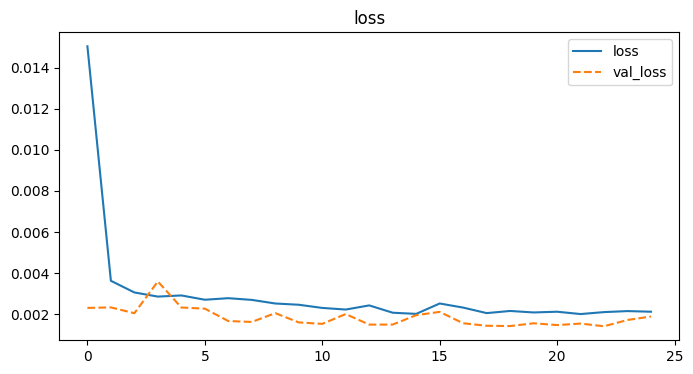

In [19]:
# Loss
fig, ax = plt.subplots(figsize=(8,4))
plt.title('loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss', linestyle='--')
plt.legend()
plt.show()



**<font size="2"><a href="#summary">Back to summary</a></font>**

----

# <div id="chap5">5. Predictions

In [20]:
# test model accuracy on existing data

actual_prices = test_data['Close'].values
total_dataset = pd.concat((train_data['Close'], test_data['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-base_day:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

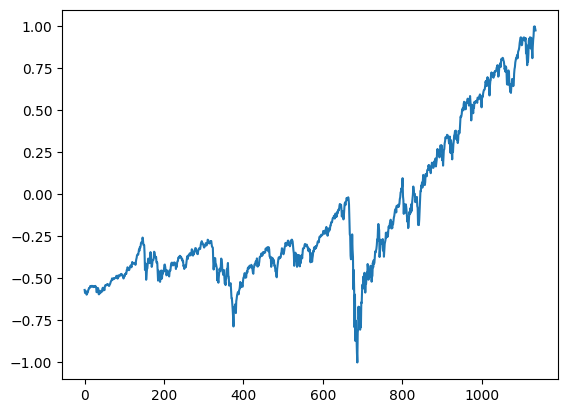

In [21]:
plt.plot(model_inputs)

In [213]:
x_test = []
y_test = []
for x in range(base_day+prediction_day, len(model_inputs)):
    x_test.append(model_inputs[x-base_day-prediction_day:x-prediction_day, 0])
    y_test.append(model_inputs[x-prediction_day:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
print(f"predicted_prices: {predicted_prices}")

35/35 [==============================] - 12s 330ms/step
predicted_prices: [[ 484.19754  483.88147  479.7373  ...  472.84827  470.7695   469.18405]
 [ 460.89566  461.8474   457.8237  ...  450.48993  448.55505  446.32617]
 [ 453.83624  454.3766   450.55295 ...  443.0669   441.08603  439.04178]
 ...
 [2296.1335  2315.2366  2296.1445  ... 2302.559   2297.4844  2307.478  ]
 [2273.7346  2295.9304  2276.7385  ... 2282.7131  2277.5073  2285.6504 ]
 [2303.4756  2323.5024  2304.844   ... 2310.5864  2305.181   2314.6577 ]]


In [198]:
type(predicted_prices)

numpy.ndarray

In [199]:
print(predicted_prices[0])
print(predicted_prices[500])

[-0.5679056  -0.5681738  -0.57169056 -0.56645054 -0.5759371  -0.5790125
 -0.58297914 -0.5775366  -0.57930064 -0.58064604]
[-0.40770102 -0.40694904 -0.4097335  -0.4067091  -0.41201368 -0.41545483
 -0.41829097 -0.41450298 -0.41672882 -0.4190783 ]


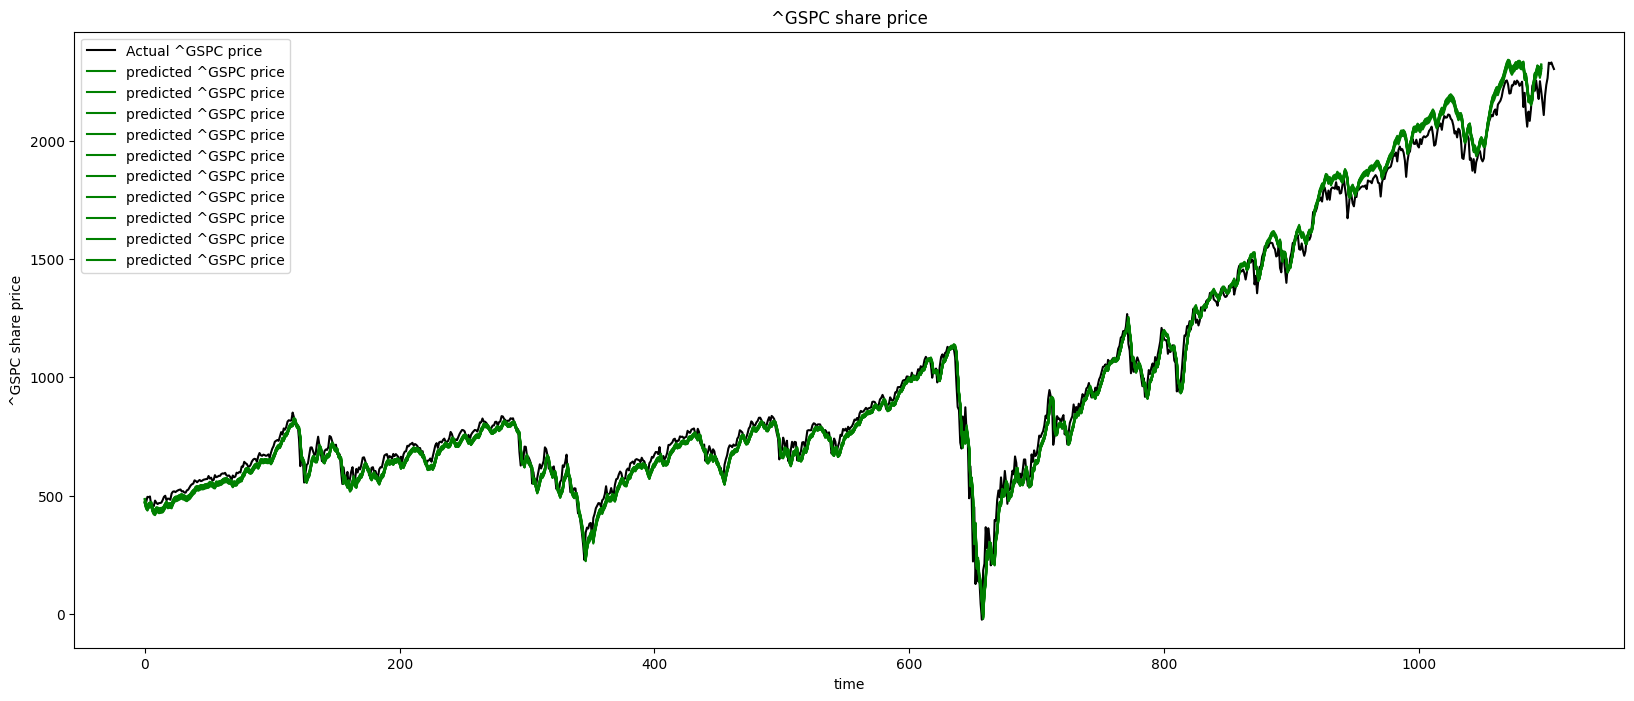

In [214]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices, color='green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.legend()
plt.show()

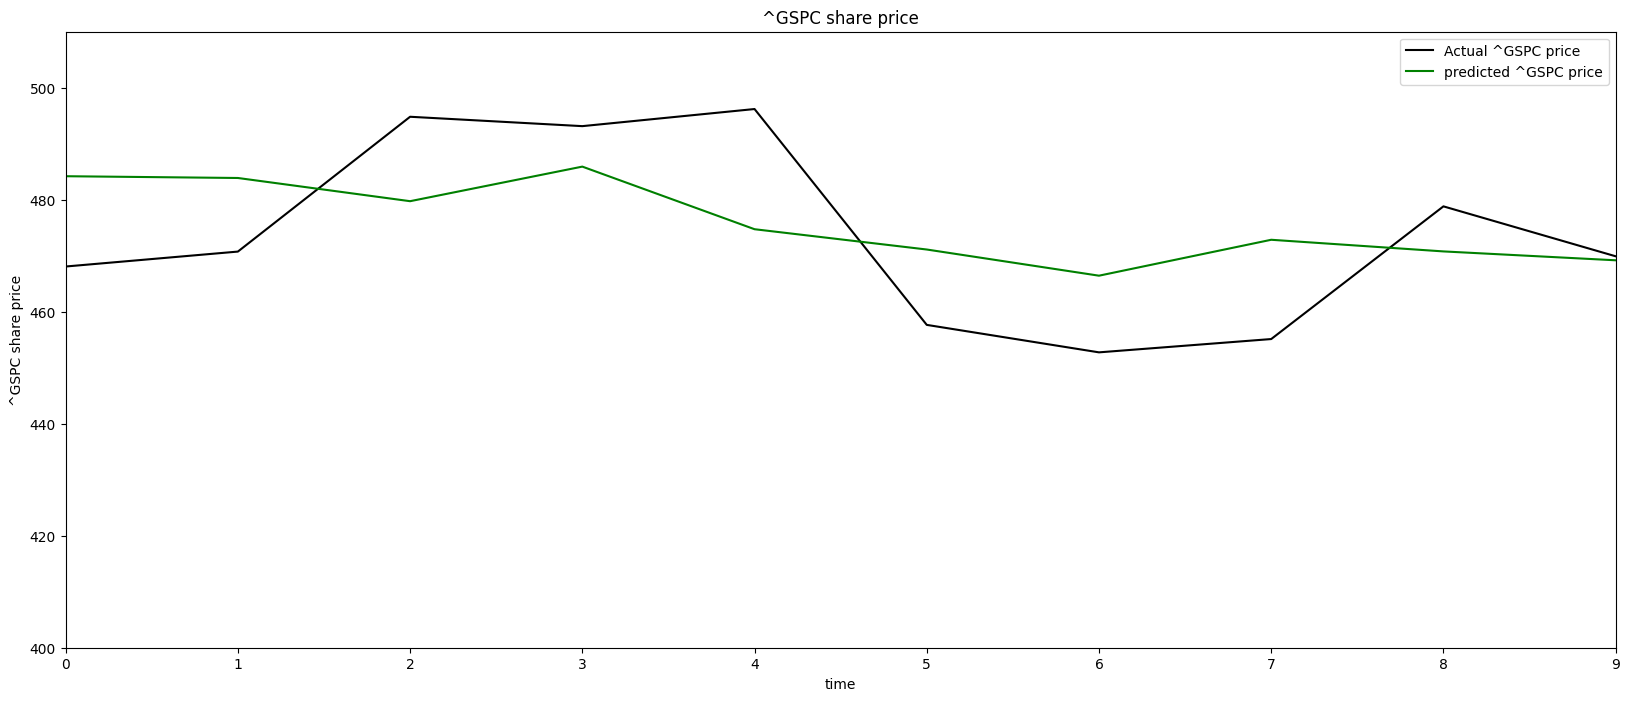

In [216]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")
plt.plot(predicted_prices[0], color= 'green', label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.xlim(0, 9)
plt.ylim(400, 510)
plt.legend()
plt.show()

In [202]:
len(predicted_prices)

1097

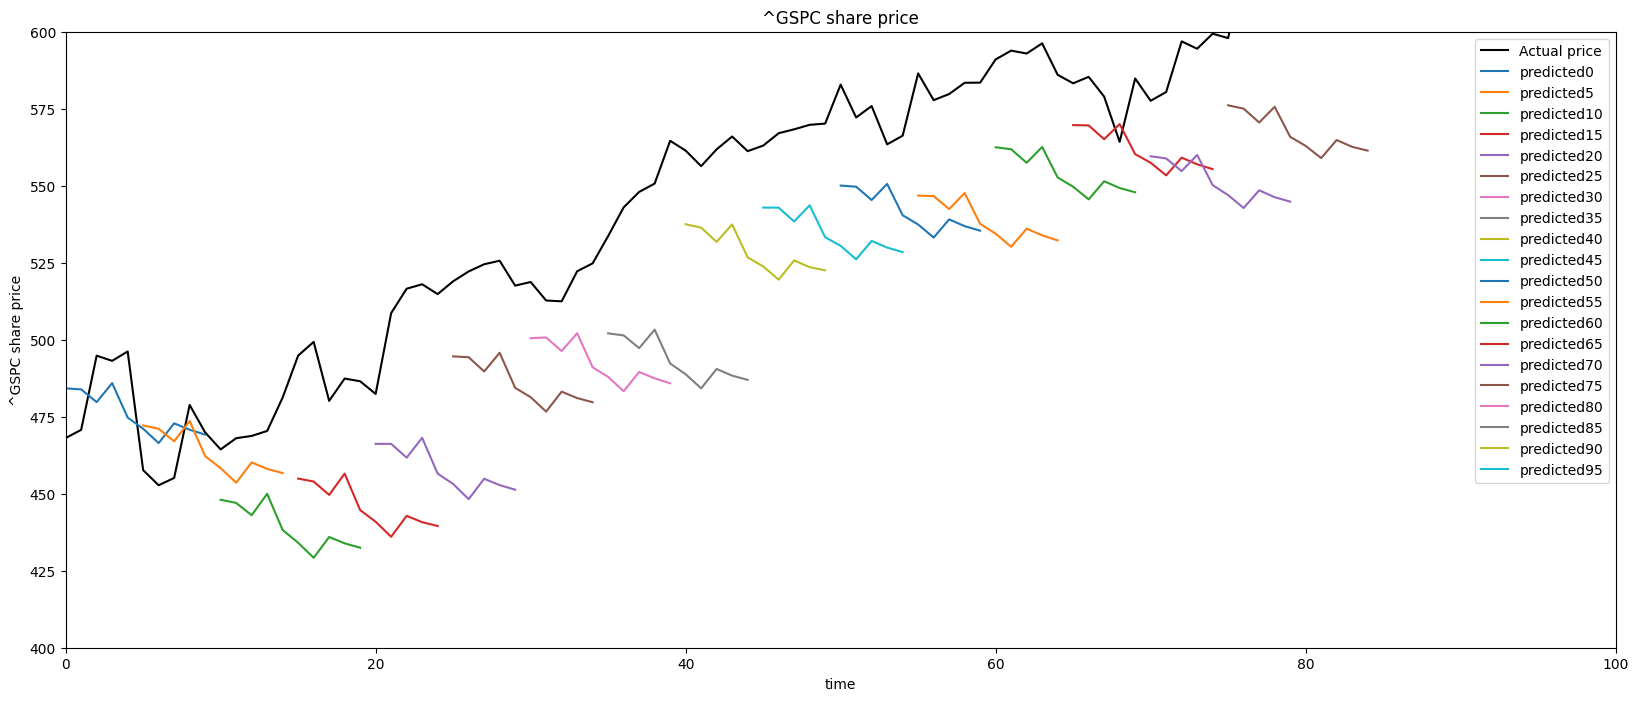

In [215]:
plt.figure(figsize=(20, 8))
plt.plot(actual_prices, color='black', label=f"Actual price")
for i in range(0, 100, 5):
    start = i
    singal = predicted_prices[start]
    plt.plot(range(start,len(singal)+start), singal, label=f"predicted{i}")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
plt.xlim(0, 100)
plt.ylim(400, 600)
plt.legend()
plt.show()

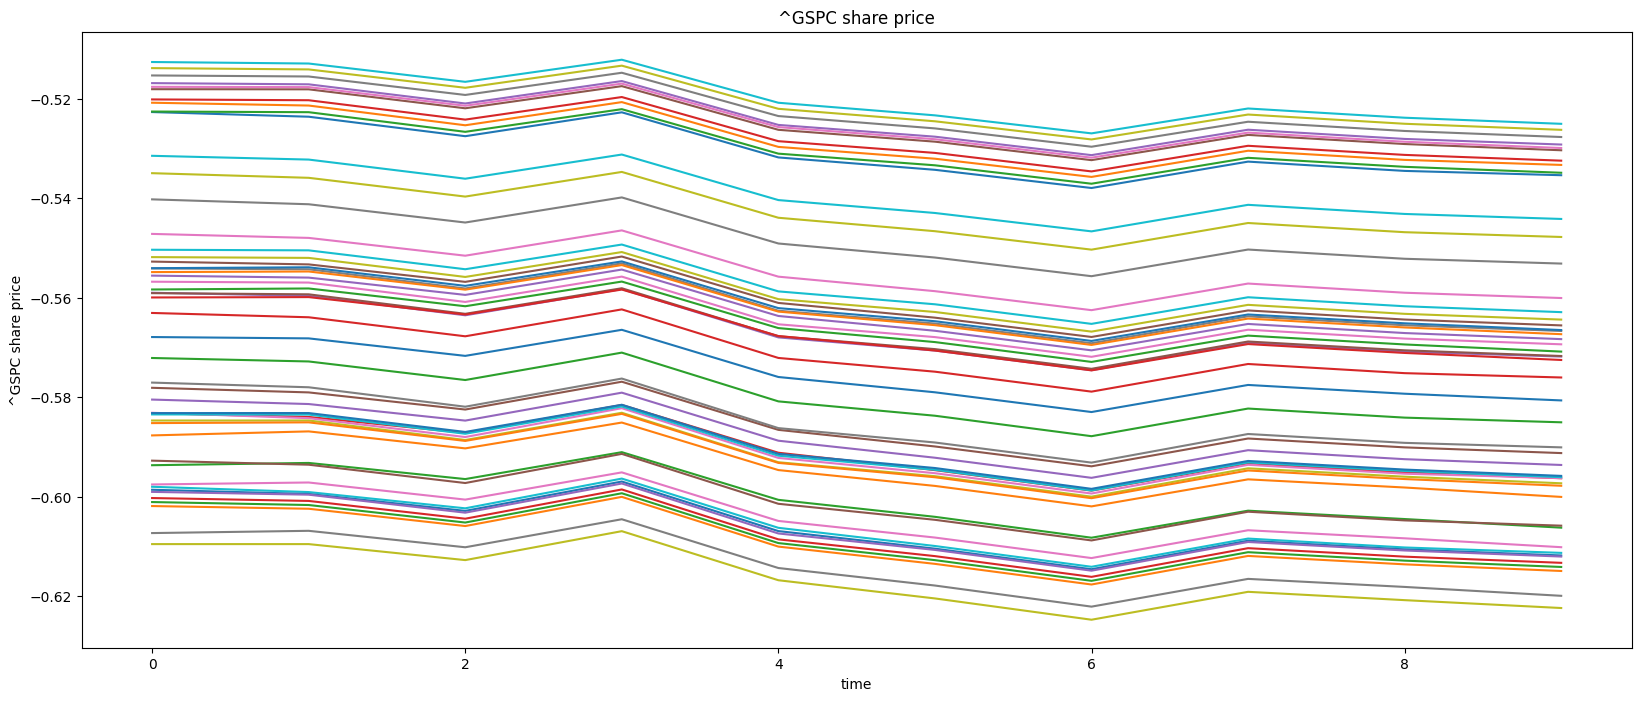

In [204]:
plt.figure(figsize=(20, 8))
for i in range(0, 50):
    plt.plot(predicted_prices[i], label=f"predicted {COMPANY} price")
plt.title(f"{COMPANY} share price")
plt.xlabel("time")
plt.ylabel(f"{COMPANY} share price")
# plt.xlim(0, 9)
# plt.ylim(400, 510)
# plt.legend()
plt.show()

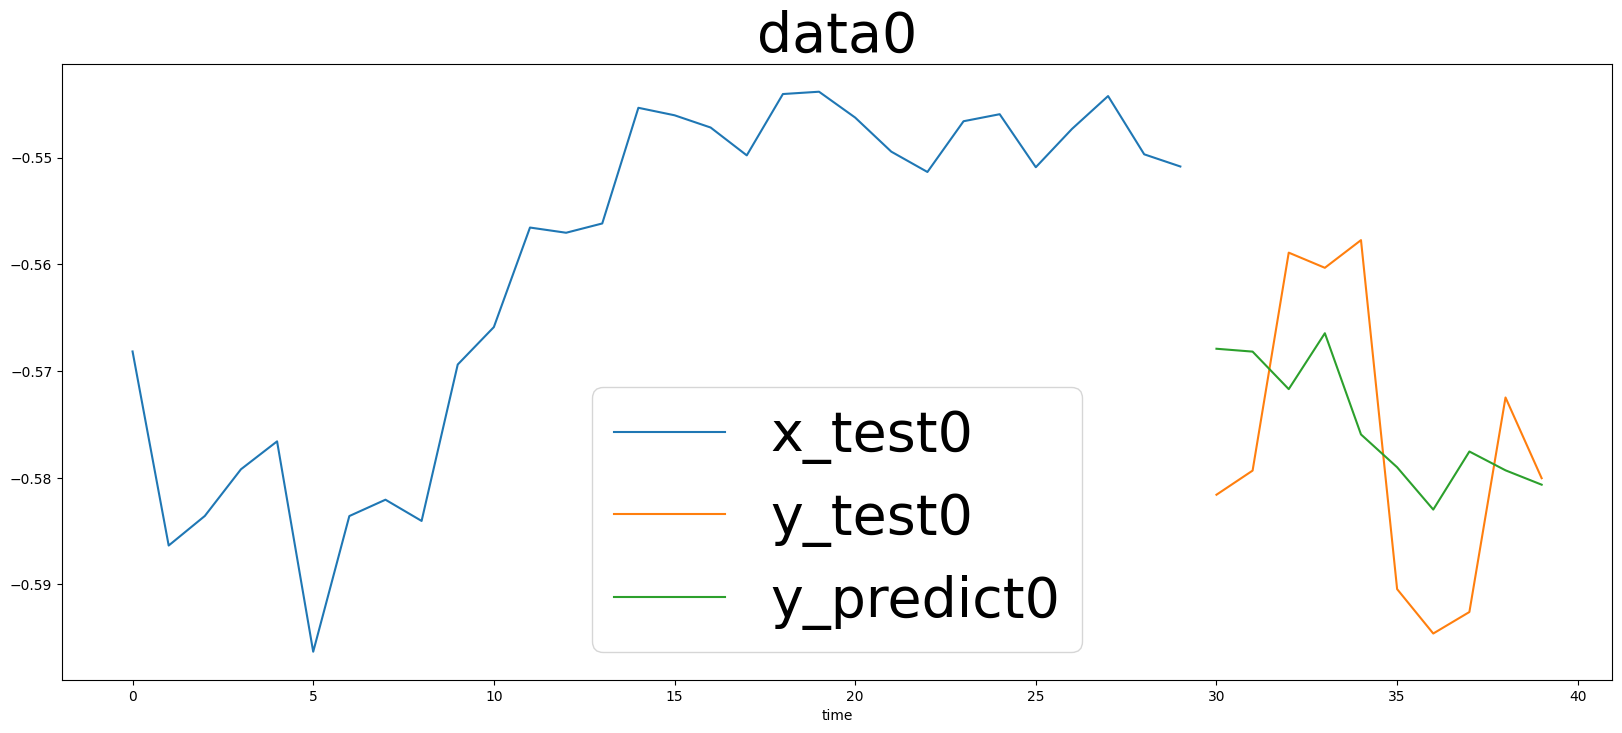

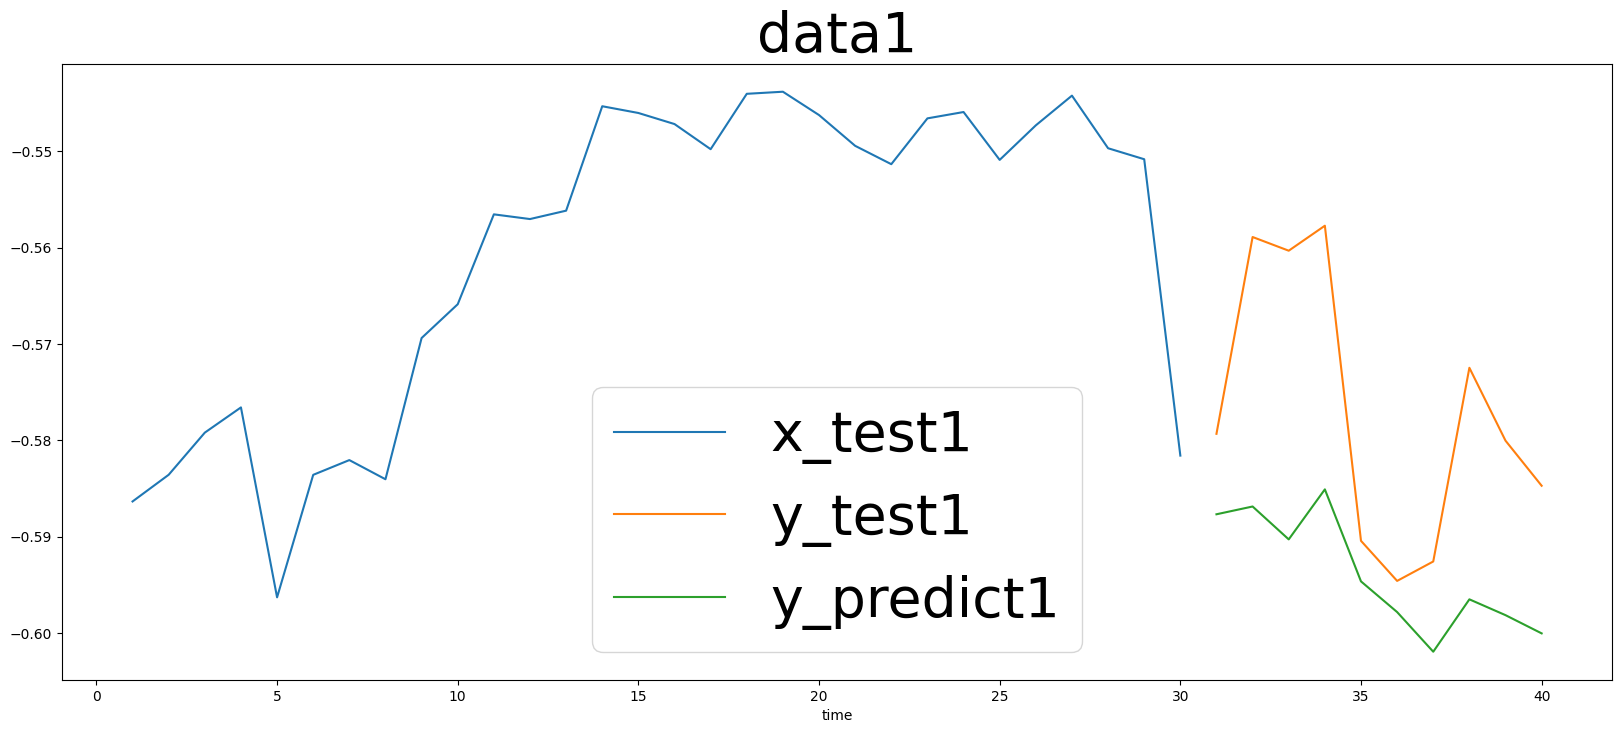

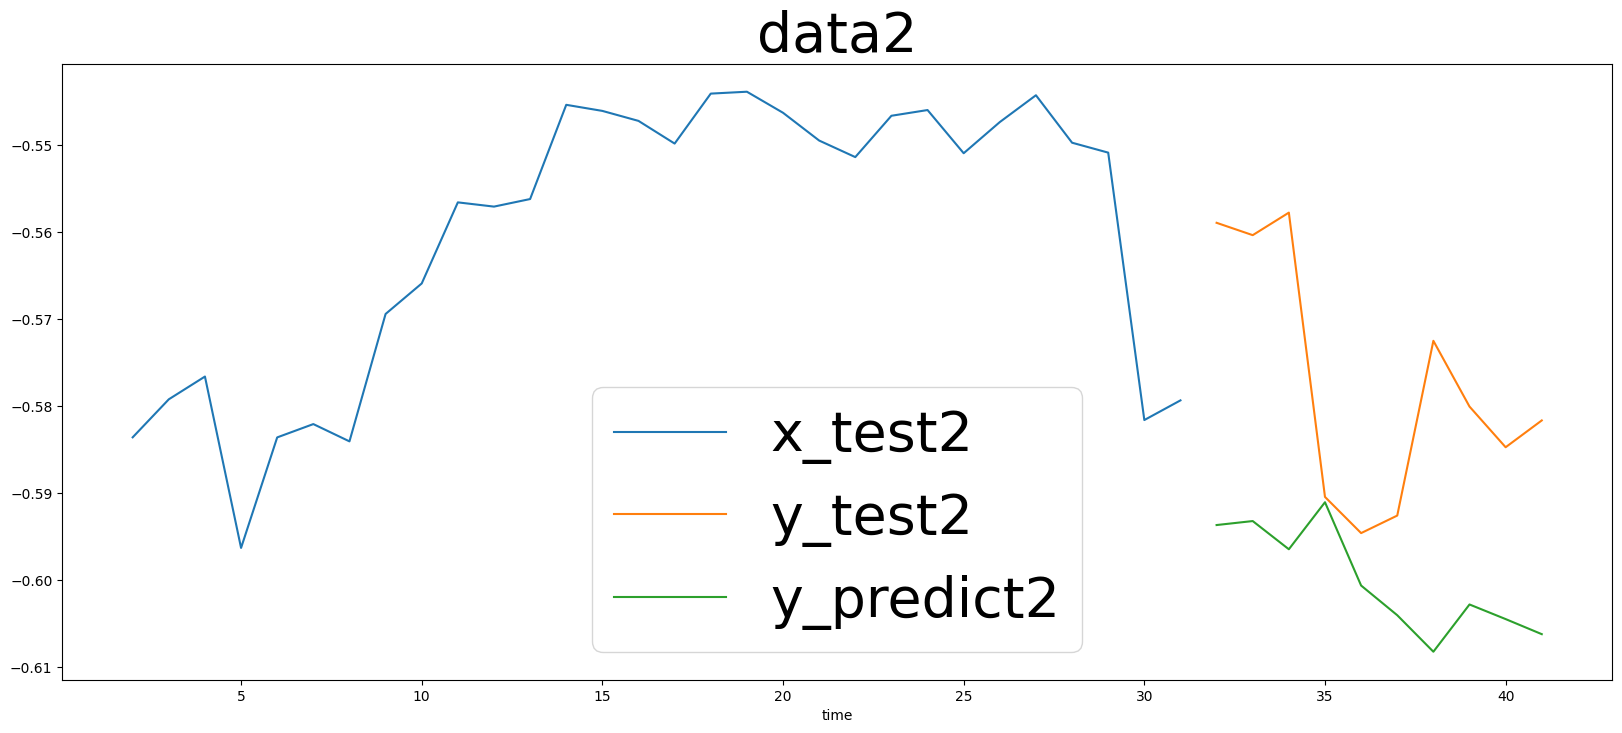

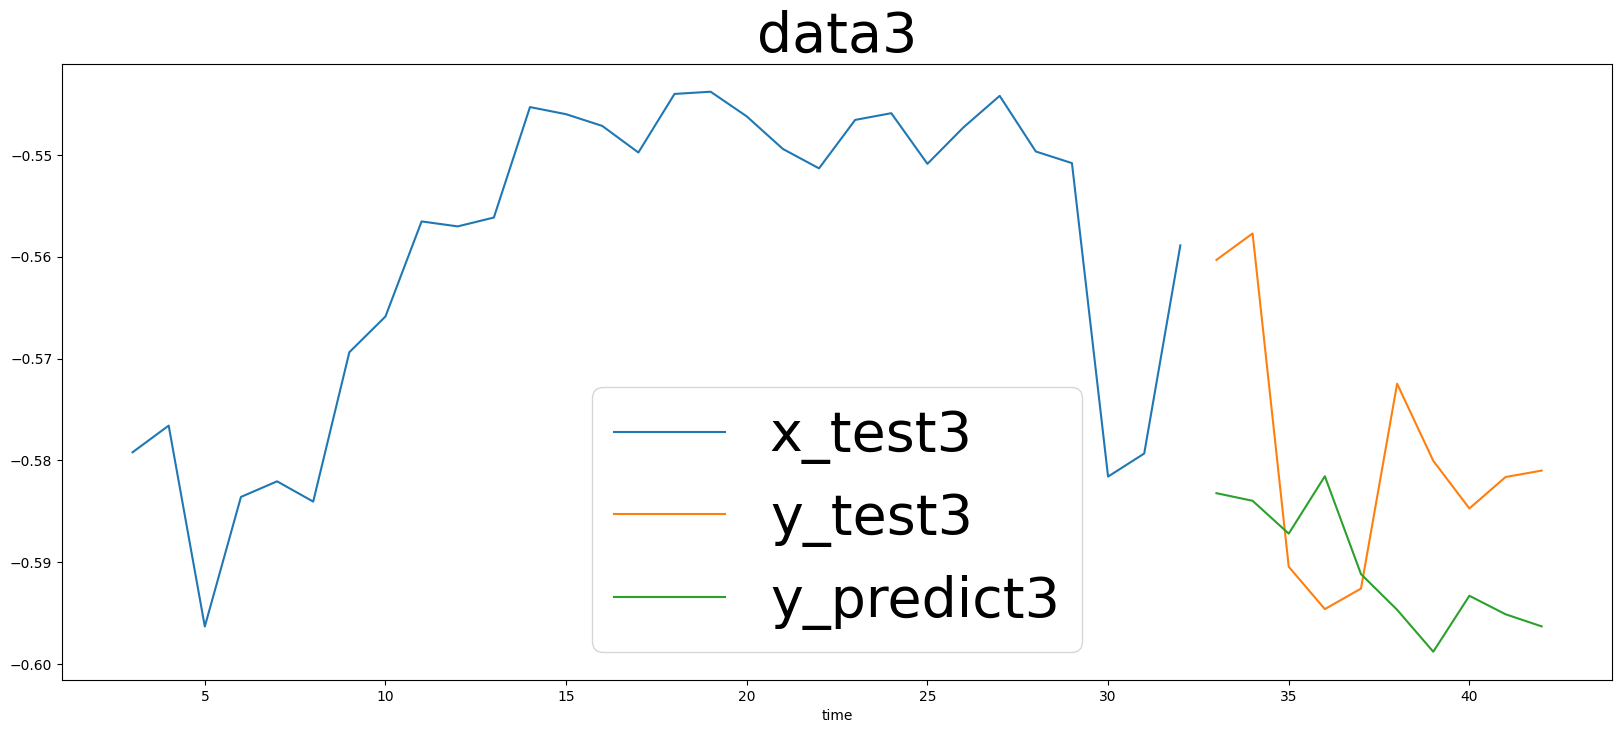

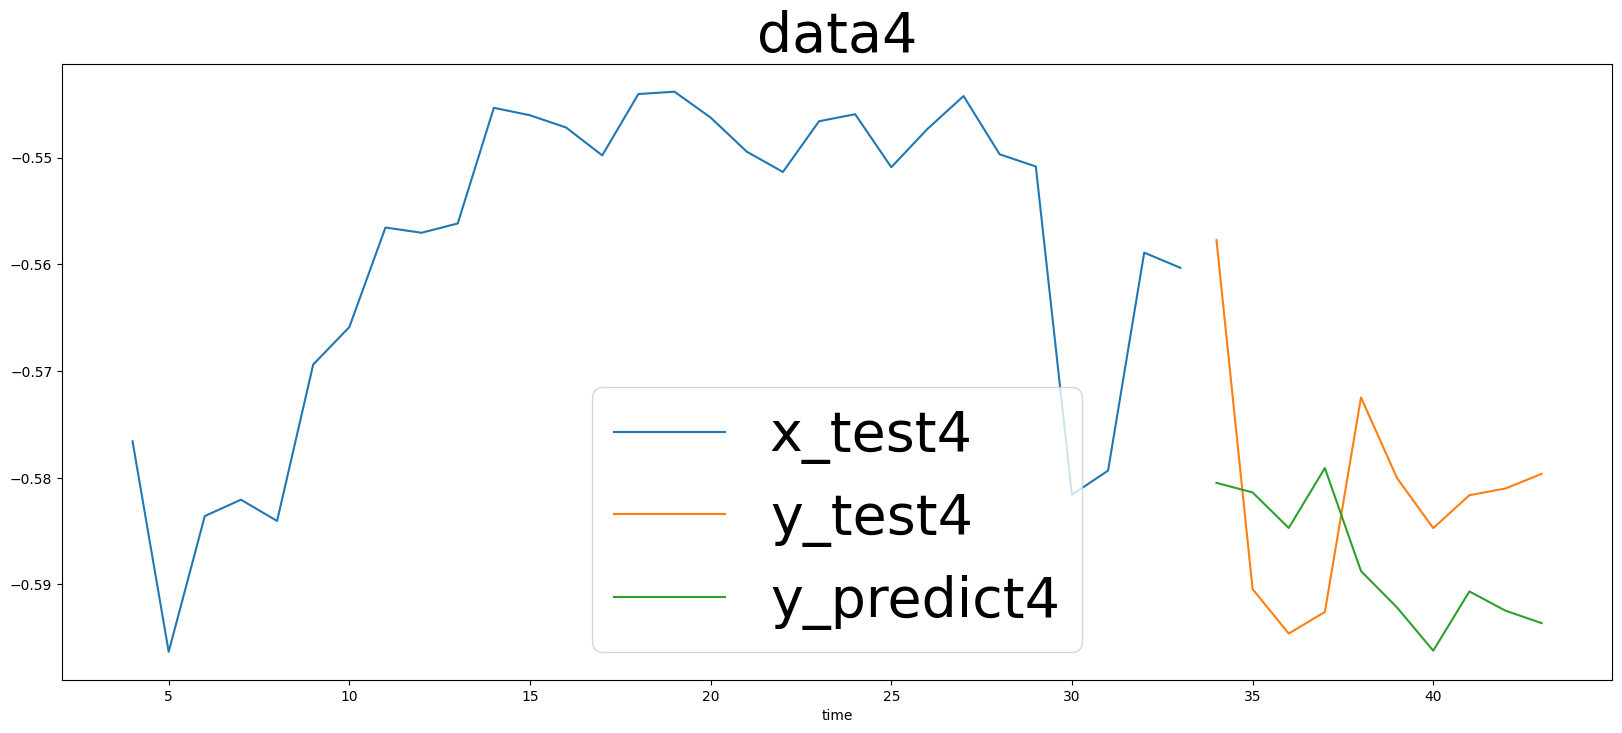

In [212]:
for num in range(0, 5):
    plt.figure(figsize=(20, 8))
    for i in range(num, num+1):
        start = i
        singal = x_test[start]
        plt.plot(range(start,len(singal)+start), singal, label=f"x_test{i}")
    for i in range(num, num+1):
        start = i
        singal = y_test[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_test{i}")
    for i in range(num, num+1):
        start = i
        singal = predicted_prices[start]
        plt.plot(range(start+len(x_test[start]),len(singal)+len(x_test[start])+start), singal, label=f"y_predict{i}")
    plt.xlabel("time")
    plt.title(f"data{i}", fontsize=40)
    plt.legend(fontsize=40)
    plt.show()

In [206]:
def find_data_pv_CL_function(data, pv_range):
    pd.options.mode.chained_assignment = None
    price = data['Close']
    data['peaks'] = pd.Series(dtype='float64')
    data['valleys'] = pd.Series(dtype='float64')
    data['pv'] = pd.Series(dtype='str')
    for idx in range(0, len(price)):
        if idx < pv_range:
            if price[idx] == price.iloc[0:pv_range*2+1].max():
                data['peaks'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'peak'
            if price[idx] == price.iloc[0:pv_range*2+1].min():
                data['valleys'].iloc[idx] = price[idx]
                data['pv'].iloc[idx] = 'valley'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].max():
            data['peaks'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'peak'
        if price[idx] == price.iloc[idx-pv_range:idx+pv_range].min():
            data['valleys'].iloc[idx] = price[idx]
            data['pv'].iloc[idx] = 'valley'


In [207]:
def find_signal_pv_function(signal_souce, pv_range, test_data):
    pd.options.mode.chained_assignment = None
    signal = {}
    for i in range(0, predicted_prices.shape[0]):
        # ------------
        data = pd.Series(signal_souce[i])
        signal[i] = pd.DataFrame()
        signal[i]['Close'] = data
        signal[i].index = test_data.index[range(i, i+predicted_prices.shape[1])]
        signal[i]['peaks'] = pd.Series(dtype='float64')
        signal[i]['valleys'] = pd.Series(dtype='float64')
        signal[i]['pv'] = pd.Series(dtype='str')
        for idx in range(0, len(data)):
            if idx < pv_range:
                if data[idx] == data.iloc[0:pv_range*2+1].max():
                    signal[i]['peaks'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'peak'
                if data[idx] == data.iloc[0:pv_range*2+1].min():
                    signal[i]['valleys'].iloc[idx] = data[idx]
                    signal[i]['pv'].iloc[idx] = 'valley'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].max():
                signal[i]['peaks'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'peak'
            if data[idx] == data.iloc[idx-pv_range:idx+pv_range].min():
                signal[i]['valleys'].iloc[idx] = data[idx]
                signal[i]['pv'].iloc[idx] = 'valley'
    return signal


In [208]:
pv_range = 2
test_data['Close'] = actual_prices
find_data_pv_CL_function(test_data, pv_range)
processed_signal = find_signal_pv_function(predicted_prices, pv_range, test_data)

KeyboardInterrupt: 

In [ ]:
def find_signal_lead_train_function(data, processed_signal):
    for p in processed_signal:
        processing_signal = processed_signal[p]
        # processing_data = data.head(len(processing_signal))
        p_data = pd.DataFrame(
            {'peaks': data['peaks'], 'count': range(len(data))})
        p_data = p_data.drop(p_data[p_data['peaks'].isna()].index)
        p_data_count = list(p_data['count'])
        p_signal = pd.DataFrame(
            {'peaks': processing_signal['peaks'], 'count': range(len(processing_signal))})
        p_signal = p_signal.drop(p_signal[p_signal['peaks'].isna()].index)
        p_signal_list = list(p_signal['count'])
        p_lead = []
        for i in range(0, len(p_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(p_data_count)):
                temp.append((p_data_count[j] - p_signal_list[i]))
                temp_abs.append(abs(p_data_count[j] - p_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            p_lead.append(temp_2)
        p_signal['lead'] = p_lead

        v_data = pd.DataFrame(
            {'valleys': data['valleys'], 'count': range(len(data))})
        v_data = v_data.drop(v_data[v_data['valleys'].isna()].index)
        v_data_count = list(v_data['count'])
        v_signal = pd.DataFrame(
            {'valleys': processing_signal['valleys'], 'count': range(len(processing_signal))})
        v_signal = v_signal.drop(
            v_signal[v_signal['valleys'].isna()].index)
        v_signal_list = list(v_signal['count'])
        v_lead = []
        for i in range(0, len(v_signal_list)):
            temp = []
            temp_abs = []
            temp_2 = []
            for j in range(0, len(v_data_count)):
                temp.append((v_data_count[j] - v_signal_list[i]))
                temp_abs.append(abs(v_data_count[j] - v_signal_list[i]))
            for k in range(0, len(temp_abs)):
                if temp_abs[k] == min(temp_abs):
                    temp_2 = temp[k]
            v_lead.append(temp_2)
        v_signal['lead'] = v_lead

        processed_signal[p]['lead'] = pd.Series(dtype='float64')
        processed_signal[p]['lead'] = p_signal['lead']
        processed_signal[p]['lead'] = v_signal['lead']


In [ ]:
find_signal_lead_train_function(test_data, processed_signal)

In [ ]:
test_data[0:11]

,Open,High,Low,Close,Adj Close,Volume,peaks,valleys,pv
Date,,,,,,,,,
2017-08-10,2465.379883,2465.379883,2437.750000,468.073617,2438.209961,3635820000,NaN,468.073617,valley
2017-08-11,2441.040039,2448.090088,2437.850098,470.738898,2441.320068,3161830000,NaN,NaN,NaN
2017-08-14,2454.959961,2468.219971,2454.959961,494.814091,2465.840088,2824320000,494.814091,NaN,peak
2017-08-15,2468.659912,2468.899902,2461.610107,493.139284,2464.610107,2922430000,NaN,NaN,NaN
2017-08-16,2468.629883,2474.929932,2463.860107,496.194458,2468.110107,2956570000,496.194458,NaN,peak
2017-08-17,2462.949951,2465.020020,2430.010010,457.649534,2430.010010,3164950000,NaN,NaN,NaN
2017-08-18,2427.639893,2440.270020,2420.689941,452.744746,2425.550049,3426970000,NaN,452.744746,valley
2017-08-21,2425.500000,2430.580078,2417.350098,455.119988,2428.370117,2803650000,NaN,NaN,NaN
2017-08-22,2433.750000,2454.770020,2433.669922,478.815054,2452.510010,2780990000,478.815054,NaN,peak


In [ ]:
processed_signal[6]

,Close,peaks,valleys,pv,lead
Date,,,,,
2017-08-18,449.278595,NaN,NaN,NaN,NaN
2017-08-21,449.742249,NaN,NaN,NaN,NaN
2017-08-22,445.689453,NaN,445.689453,valley,-2.0
2017-08-23,452.137451,452.137451,NaN,peak,NaN
2017-08-24,440.636292,NaN,NaN,NaN,NaN
2017-08-25,436.700317,NaN,NaN,NaN,NaN
2017-08-28,431.843567,NaN,431.843567,valley,0.0
2017-08-29,438.431274,438.431274,NaN,peak,NaN
2017-08-30,436.519928,NaN,NaN,NaN,NaN


In [ ]:
def get_first_lead_function(processed_signal):
    first_date = {}
    lead = {}
    pv = {}
    for i in processed_signal:
        temp = processed_signal[i].loc[list(
            processed_signal[i]['lead'].dropna().index)[0]]
        first_date[i] = list(processed_signal[i]
                             ['lead'].dropna().index)[0]
        lead[i] = temp['lead']
        pv[i] = temp['pv']
    return first_date, lead, pv


In [ ]:
first_date, lead, pv = get_first_lead_function(processed_signal)

In [ ]:
def built_result_table_function(processed_signal, lead, pv):
    result_table = pd.DataFrame(columns=[
        's_date', 't_date', 'lead', 'ans_date', 'pv'])
    for i in processed_signal:
        result_table.loc[i, 'lead'] = lead[i]
        result_table.loc[i, 'pv'] = pv[i]
        result_table.loc[i, 's_date'] = processed_signal[i].index[0]
    return result_table


In [ ]:
result_table = built_result_table_function(processed_signal, lead, pv)
result_table

,s_date,t_date,lead,ans_date,pv
0,2017-08-10 00:00:00,NaN,-2.0,NaN,valley
1,2017-08-11 00:00:00,NaN,-2.0,NaN,valley
2,2017-08-14 00:00:00,NaN,-2.0,NaN,valley
3,2017-08-15 00:00:00,NaN,-2.0,NaN,valley
4,2017-08-16 00:00:00,NaN,-2.0,NaN,valley
...,...,...,...,...,...
1092,2021-12-10 00:00:00,NaN,1.0,NaN,peak
1093,2021-12-13 00:00:00,NaN,1.0,NaN,peak
1094,2021-12-14 00:00:00,NaN,1.0,NaN,peak
1095,2021-12-15 00:00:00,NaN,1.0,NaN,peak


In [ ]:
data.iloc[data.index.get_loc(result_table.loc[0, 's_date'])-2]

Open         2.478350e+03
High         2.490870e+03
Low          2.470320e+03
Close        5.056732e+02
Adj Close    2.474920e+03
Volume       3.347480e+09
Name: 2017-08-08 00:00:00, dtype: float64

In [ ]:
def result_table_process_function(result_table, data, first_date):
    for i in result_table.index:
        t_date = first_date[i]
        result_table.loc[i, 't_date'] = t_date
        ans = data.iloc[int(data.index.get_loc(t_date) + result_table.loc[i, 'lead'])].name
        result_table.loc[i, 'ans_date'] = ans

In [ ]:
result_table_process_function(result_table, data, first_date)

In [ ]:
result_table

,s_date,t_date,lead,ans_date,pv
0,2017-08-10 00:00:00,2017-08-14 00:00:00,-2.0,2017-08-10 00:00:00,valley
1,2017-08-11 00:00:00,2017-08-15 00:00:00,-2.0,2017-08-11 00:00:00,valley
2,2017-08-14 00:00:00,2017-08-16 00:00:00,-2.0,2017-08-14 00:00:00,valley
3,2017-08-15 00:00:00,2017-08-17 00:00:00,-2.0,2017-08-15 00:00:00,valley
4,2017-08-16 00:00:00,2017-08-18 00:00:00,-2.0,2017-08-16 00:00:00,valley
...,...,...,...,...,...
1092,2021-12-10 00:00:00,2021-12-13 00:00:00,1.0,2021-12-14 00:00:00,peak
1093,2021-12-13 00:00:00,2021-12-14 00:00:00,1.0,2021-12-15 00:00:00,peak
1094,2021-12-14 00:00:00,2021-12-15 00:00:00,1.0,2021-12-16 00:00:00,peak
1095,2021-12-15 00:00:00,2021-12-16 00:00:00,1.0,2021-12-17 00:00:00,peak


In [ ]:
def compute_final_error_function(result_table):
    final_error = round(
        sum([abs(ele) for ele in result_table['lead']]) / len(result_table['lead']), 2)
    return final_error


In [ ]:
compute_final_error_function(result_table)

1.51

In [ ]:
def evaluate_model(processed_signal, test_data_start_list, all_data, best_fit_harm, best_error, first_date, lead, pv, data_range):
    result_table = built_result_table_function(
        processed_signal, test_data_start_list, lead, pv, best_error, best_fit_harm)
    result_table_process_function(
        result_table, all_data, first_date, data_range)
    final_error = compute_final_error_function(result_table)
    return result_table, final_error